# Discovery vs Prediction Framework Overview

This notebook provides a comprehensive overview of the two modes of Aladynoulli:
1. **Discovery Mode**: Joint phi estimation for understanding disease biology
2. **Prediction Mode**: Fixed phi for clinical predictions

We also demonstrate:
- How thetas update over time with different washout periods
- How to calculate GWAS AUC without genotypes (G) using signature loadings


---
## Part 1: Discovery vs Prediction Framework

### 🔬 Discovery Mode: Joint Phi Estimation

**Purpose**: Learn disease signatures (phi) from data to understand disease connections

**How it works**:
- **Phi is learned** from the data (joint estimation with lambda)
- Model learns which diseases cluster together into signatures
- Used for understanding disease biology and relationships
- **Lambda** (individual signature loadings) is also learned
- **Theta** = softmax(lambda) = individual signature proportions over time

**Location**: `/Dropbox/enrollment_retrospective_full/`
- Generated by: `run_full_retrospective.sh` → `run_aladyn_batch.py`
- Outputs: `enrollment_model_W0.0001_batch_*_*.pt` (contains learned phi and lambda)

**Key Characteristics**:
- Phi can vary between batches (batch-specific disease signatures)
- Theta reflects individual signature loadings learned jointly with phi
- Best for: Understanding disease biology, pathway discovery, heritability analysis

---

### 🎯 Prediction Mode: Fixed Phi

**Purpose**: Make predictions using pre-learned signatures (stable, generalizable)

**How it works**:
- **Phi is fixed** from master checkpoints (pre-learned signatures)
- Only **lambda** (individual signature loadings) is estimated
- **Theta** = softmax(lambda) = individual signature proportions over time
- Used for clinical prediction and performance evaluation

**Location**: `/Dropbox/models_fromAWS_enrollment_predictions_fixedphi_RETROSPECTIVE_pooled/`
- Generated by: `run_aladyn_predict_with_master.py` (on AWS)
- Outputs: `pi_enroll_fixedphi_sex_*.pt` (pi tensors for predictions)

**Key Characteristics**:
- Phi is stable across all patients (from master checkpoint)
- Theta reflects individual signature loadings given fixed phi
- Best for: Clinical predictions, performance evaluation, washout analyses

---

### Comparison Table

| Aspect | Discovery Mode | Prediction Mode |
|--------|---------------|------------------|
| **Phi** | Learned (joint) | Fixed (from master) |
| **Lambda** | Learned (joint) | Learned (phi fixed) |
| **Theta** | softmax(lambda) | softmax(lambda) |
| **Purpose** | Disease biology | Clinical prediction |
| **Stability** | Batch-specific | Stable across all |
| **Use Cases** | Pathway discovery, heritability | AUC, washout, age offset |


---
## Part 2: Timeline of Theta Updates

### How Thetas Update Over Time

Thetas (signature proportions) update as more data becomes available. This is demonstrated using the **age offset** approach:

- **Age Offset 0**: Predict at enrollment age using data up to enrollment
- **Age Offset 5**: Predict at enrollment+5 years using data up to enrollment+5 years
- **Age Offset 9**: Predict at enrollment+9 years using data up to enrollment+9 years

As more data becomes available (higher age offset), the model learns more about each patient's signature loadings, and thetas update accordingly.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import torch
from pathlib import Path
import pandas as pd

# Example: Load thetas from different age offsets
# This demonstrates how thetas update as more data becomes available

print("="*80)
print("THETA UPDATE TIMELINE DEMONSTRATION")
print("="*80)
print("\nThis shows how individual signature loadings (thetas) update")
print("as more data becomes available over time.")
print("\nAge Offset 0: Data up to enrollment age")
print("Age Offset 5: Data up to enrollment+5 years")
print("Age Offset 9: Data up to enrollment+9 years")
print("\nAs offset increases, thetas become more refined based on observed events.")


THETA UPDATE TIMELINE DEMONSTRATION

This shows how individual signature loadings (thetas) update
as more data becomes available over time.

Age Offset 0: Data up to enrollment age
Age Offset 5: Data up to enrollment+5 years
Age Offset 9: Data up to enrollment+9 years

As offset increases, thetas become more refined based on observed events.


In [6]:
# Example visualization function for theta updates
def visualize_theta_updates(patient_idx, signature_idx, thetas_by_offset, timepoints):
    """
    Visualize how theta for a specific patient and signature updates across age offsets
    
    Parameters:
    - patient_idx: Patient index
    - signature_idx: Signature index to plot
    - thetas_by_offset: Dict {offset: theta_tensor} where theta_tensor is [N, K, T]
    - timepoints: Array of timepoints (ages)
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Theta trajectory over time for different offsets
    ax1 = axes[0]
    for offset, thetas in sorted(thetas_by_offset.items()):
        theta_traj = thetas[patient_idx, signature_idx, :]
        ax1.plot(timepoints, theta_traj, label=f'Offset {offset}', marker='o', markersize=3)
    
    ax1.set_xlabel('Age (years)', fontsize=12)
    ax1.set_ylabel(f'Theta (Signature {signature_idx})', fontsize=12)
    ax1.set_title(f'Patient {patient_idx}: Theta Updates Across Age Offsets', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Theta AUC (area under curve) for different offsets
    ax2 = axes[1]
    offsets = sorted(thetas_by_offset.keys())
    theta_aucs = []
    
    for offset in offsets:
        thetas = thetas_by_offset[offset]
        theta_traj = thetas[patient_idx, signature_idx, :]
        # Calculate AUC using trapezoidal integration
        auc = np.trapz(theta_traj, timepoints)
        theta_aucs.append(auc)
    
    ax2.plot(offsets, theta_aucs, marker='o', linewidth=2, markersize=8)
    ax2.set_xlabel('Age Offset (years)', fontsize=12)
    ax2.set_ylabel(f'Theta AUC (Signature {signature_idx})', fontsize=12)
    ax2.set_title(f'Patient {patient_idx}: Theta AUC vs Age Offset', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

print("\nVisualization function created.")
print("\nTo use this function, you would load thetas from different age offsets:")
print("  thetas_by_offset = {")
print("      0: load_thetas(offset=0),  # Enrollment only")
print("      5: load_thetas(offset=5),  # Enrollment + 5 years")
print("      9: load_thetas(offset=9)   # Enrollment + 9 years")
print("  }")



Visualization function created.

To use this function, you would load thetas from different age offsets:
  thetas_by_offset = {
      0: load_thetas(offset=0),  # Enrollment only
      5: load_thetas(offset=5),  # Enrollment + 5 years
      9: load_thetas(offset=9)   # Enrollment + 9 years
  }


Loading model from: /Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_retrospective_full/enrollment_model_W0.0001_batch_40000_50000.pt
Loaded lambda: shape = (10000, 21, 52) (N=10000, K=21, T=52)
Computed theta: shape = (10000, 21, 52)

Loading Y tensor and disease names...
  Loaded Y tensor, subsetting to batch 40000-50000
  Loaded 349 disease names
  First few: ['nan', '1.0', '2.0', '3.0', '4.0']

Loaded cluster assignments: shape (348,)
  Cluster assignments map diseases to signatures (clusters)

Signature 5 (cluster 5) diseases: 7 diseases
  Examples: ['52.0', '111.0', '112.0', '113.0', '114.0']
Signature 6 (cluster 6) diseases: 8 diseases
  Examples: ['13.0', '24.0', '25.0', '26.0', '27.0']

✓ Found patient 4986:
  Sig 5 disease (52.0) at time 34 with sig5 loading=0.630
  Sig 6 disease (25.0) at time 50 with sig6 loading=0.244

Visualizing patient 4986

Checking for disease events for patient 4986...
  Checking 7 sig 5 diseases...
    Found sig 5 disease at age 64: 52.0 (s

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_29579/1204367522.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = list(cm.get_cmap('tab20')(np.linspace(0, 1, K)))


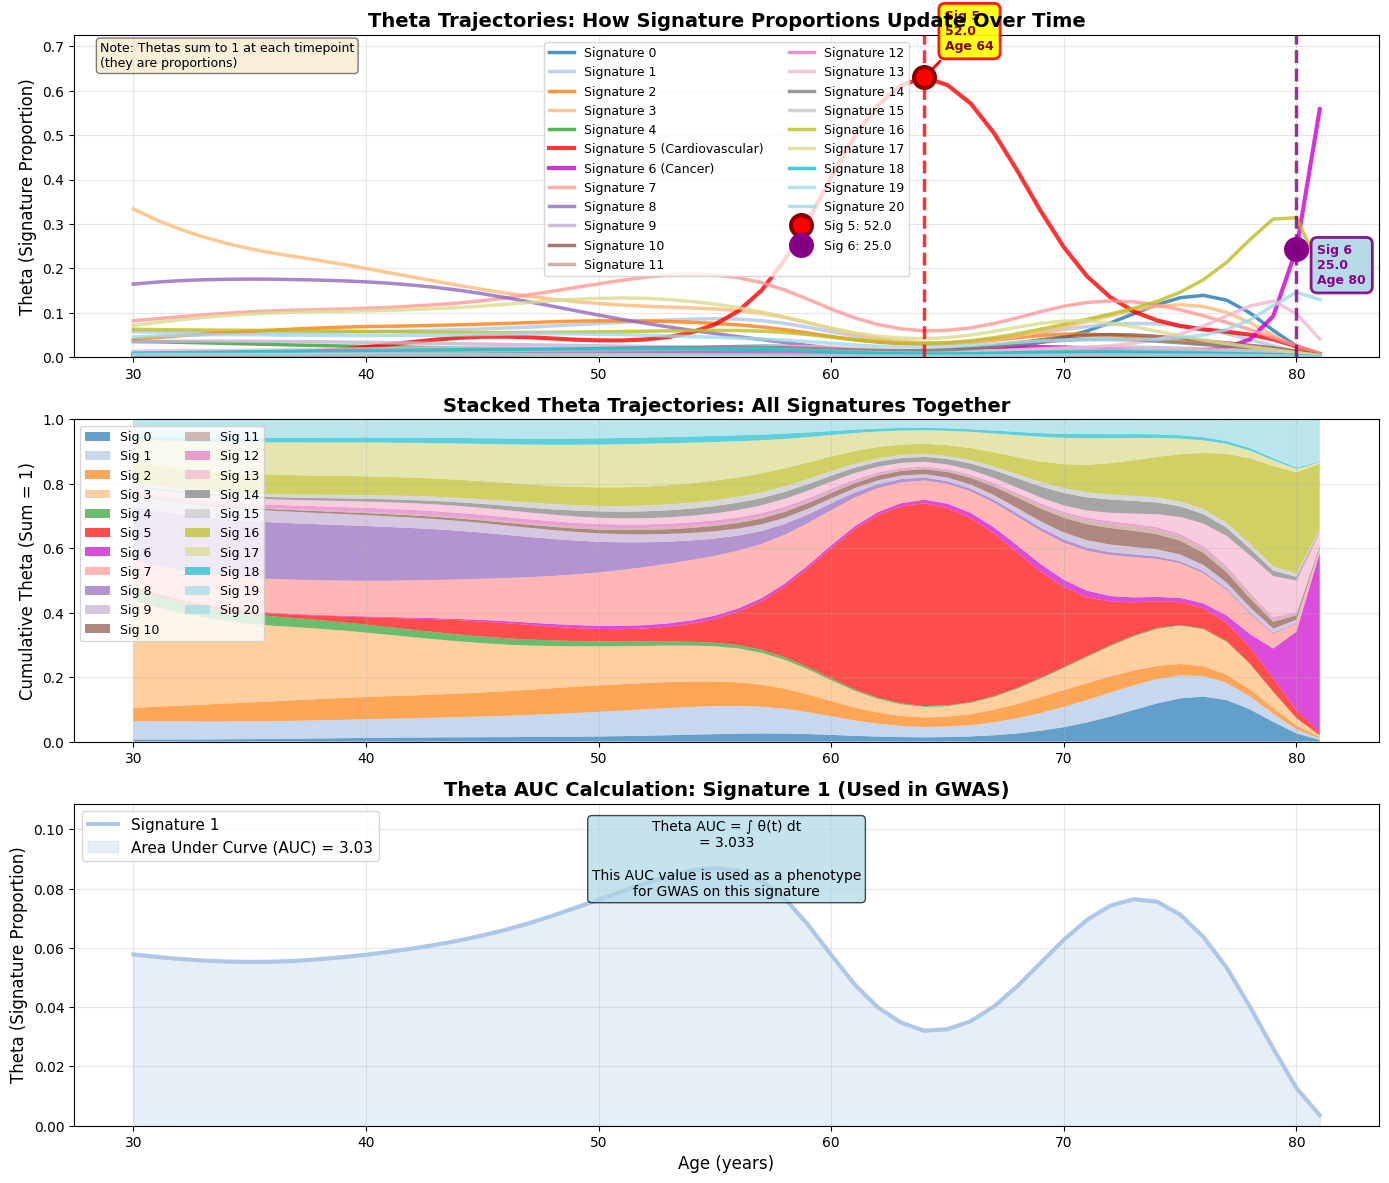


THETA TRAJECTORY SUMMARY

Model: enrollment_model_W0.0001_batch_40000_50000.pt
Patient 4986 has 21 signatures tracked over 52 timepoints (ages 30-81)

Theta statistics (mean across timepoints):
  Signature 0: mean=0.031, AUC=1.60
  Signature 1: mean=0.059, AUC=3.03
  Signature 2: mean=0.054, AUC=2.80
  Signature 3: mean=0.128, AUC=6.47
  Signature 4: mean=0.013, AUC=0.68
  Signature 5: mean=0.149, AUC=7.77
  Signature 6: mean=0.027, AUC=1.11
  Signature 7: mean=0.112, AUC=5.76
  Signature 8: mean=0.076, AUC=3.86
  Signature 9: mean=0.024, AUC=1.22
  Signature 10: mean=0.018, AUC=0.92
  Signature 11: mean=0.006, AUC=0.33
  Signature 12: mean=0.009, AUC=0.44
  Signature 13: mean=0.029, AUC=1.47
  Signature 14: mean=0.018, AUC=0.95
  Signature 15: mean=0.013, AUC=0.68
  Signature 16: mean=0.083, AUC=4.17
  Signature 17: mean=0.083, AUC=4.30
  Signature 18: mean=0.013, AUC=0.69
  Signature 19: mean=0.050, AUC=2.49
  Signature 20: mean=0.005, AUC=0.28

✓ Thetas sum to 1 at each timepoint: 

In [7]:
# Sample Theta Plot: Visualize theta trajectories updating over time
# Using actual model outputs from enrollment_retrospective_full
# Similar to patient_timeline_app.py - shows how thetas evolve and AUC calculation

from pathlib import Path
import glob

# Load actual model checkpoint
model_dir = Path.home() / "Library" / "CloudStorage" / "Dropbox" / "enrollment_retrospective_full"
model_pattern = "enrollment_model_W0.0001_batch_*_*.pt"

# Find available model files
model_files = list(model_dir.glob(model_pattern))

if not model_files:
    raise FileNotFoundError(f"Could not find model files matching {model_pattern} in {model_dir}")

# Load the first available model file
model_path = model_files[0]
print(f"Loading model from: {model_path}")

checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
state_dict = checkpoint['model_state_dict']

# Extract lambda (raw signature loadings)
lambda_ = state_dict['lambda_']  # Shape: (N, K, T)
if torch.is_tensor(lambda_):
    lambda_ = lambda_.detach().cpu().numpy()

# Calculate theta from lambda using softmax
# Theta = softmax(lambda) along the signature dimension (axis=1)
N, K, T = lambda_.shape
print(f"Loaded lambda: shape = {lambda_.shape} (N={N}, K={K}, T={T})")

# Compute theta using softmax
def softmax_theta(lambda_array):
    """Compute theta = softmax(lambda) along signature dimension."""
    # lambda_array shape: (N, K, T)
    # Reshape to (N*T, K) for softmax
    lambda_reshaped = lambda_array.transpose(0, 2, 1).reshape(-1, K)
    # Compute softmax
    exp_lambda = np.exp(lambda_reshaped - np.max(lambda_reshaped, axis=1, keepdims=True))
    theta_reshaped = exp_lambda / np.sum(exp_lambda, axis=1, keepdims=True)
    # Reshape back to (N, K, T)
    theta = theta_reshaped.reshape(N, T, K).transpose(0, 2, 1)
    return theta

thetas_all = softmax_theta(lambda_)  # Shape: (N, K, T)
print(f"Computed theta: shape = {thetas_all.shape}")

# Load Y tensor and disease_names to find patients with MI and cancer
print("\nLoading Y tensor and disease names...")
data_dir = Path.home() / "Library" / "CloudStorage" / "Dropbox-Personal" / "data_for_running"
Y_path = data_dir / "Y_tensor.pt"
disease_names_path = data_dir / "disease_names.csv"

if Y_path.exists():
    Y_full = torch.load(Y_path, map_location='cpu', weights_only=False)
    if torch.is_tensor(Y_full):
        Y_full = Y_full.detach().cpu().numpy()
    
    # Get batch indices from model filename (e.g., batch_0_10000 -> indices 0-10000)
    import re
    batch_match = re.search(r'batch_(\d+)_(\d+)', model_path.name)
    if batch_match:
        start_idx = int(batch_match.group(1))
        end_idx = int(batch_match.group(2))
        Y_batch = Y_full[start_idx:end_idx]
        print(f"  Loaded Y tensor, subsetting to batch {start_idx}-{end_idx}")
    else:
        Y_batch = Y_full[:N]  # Use first N patients
        print(f"  Loaded Y tensor, using first {N} patients")
else:
    Y_batch = None
    print("  Warning: Y tensor not found, cannot filter by disease")

if disease_names_path.exists():
    disease_names_df = pd.read_csv(disease_names_path, header=None)
    disease_names = disease_names_df.iloc[:, 0].astype(str).tolist()
    print(f"  Loaded {len(disease_names)} disease names")
    print(f"  First few: {disease_names[:5]}")
else:
    disease_names = None
    print("  Warning: disease_names.csv not found")

# Find patient with diseases from signature 5 and signature 6
patient_idx = None
sig5_disease_indices = []
sig6_disease_indices = []

if Y_batch is not None and disease_names is not None:
    # Load cluster assignments to find which diseases belong to sig 5 and sig 6
    clusters_path = Path.home() / "Library" / "CloudStorage" / "Dropbox-Personal" / "data_for_running" / "initial_clusters_400k.pt"
    
    if clusters_path.exists():
        clusters = torch.load(clusters_path, map_location='cpu', weights_only=False)
        if torch.is_tensor(clusters):
            clusters = clusters.detach().cpu().numpy()
        
        print(f"\nLoaded cluster assignments: shape {clusters.shape}")
        print(f"  Cluster assignments map diseases to signatures (clusters)")
        
        # Find diseases in signature 5 (cluster 5) and signature 6 (cluster 6)
        sig5_disease_indices = np.where(clusters == 5)[0].tolist()
        sig6_disease_indices = np.where(clusters == 6)[0].tolist()
        
        print(f"\nSignature 5 (cluster 5) diseases: {len(sig5_disease_indices)} diseases")
        if len(sig5_disease_indices) > 0:
            print(f"  Examples: {[disease_names[i] for i in sig5_disease_indices[:5]]}")
        
        print(f"Signature 6 (cluster 6) diseases: {len(sig6_disease_indices)} diseases")
        if len(sig6_disease_indices) > 0:
            print(f"  Examples: {[disease_names[i] for i in sig6_disease_indices[:5]]}")
        
        # Find patients with diseases from both sig 5 and sig 6
        candidates = []
        for n in range(min(N, Y_batch.shape[0])):
            # Check if patient has any sig 5 disease
            has_sig5_disease = False
            sig5_disease_times = []
            sig5_disease_idx = None
            
            for d_idx in sig5_disease_indices:
                if d_idx < Y_batch.shape[1] and np.any(Y_batch[n, d_idx, :] > 0.5):
                    has_sig5_disease = True
                    times = np.where(Y_batch[n, d_idx, :] > 0.5)[0]
                    sig5_disease_times.extend([(t, d_idx) for t in times])
                    if sig5_disease_idx is None:
                        sig5_disease_idx = d_idx
            
            # Check if patient has any sig 6 disease
            has_sig6_disease = False
            sig6_disease_times = []
            sig6_disease_idx = None
            
            for d_idx in sig6_disease_indices:
                if d_idx < Y_batch.shape[1] and np.any(Y_batch[n, d_idx, :] > 0.5):
                    has_sig6_disease = True
                    times = np.where(Y_batch[n, d_idx, :] > 0.5)[0]
                    sig6_disease_times.extend([(t, d_idx) for t in times])
                    if sig6_disease_idx is None:
                        sig6_disease_idx = d_idx
            
            if has_sig5_disease and has_sig6_disease:
                # Get first sig 5 disease time and sig 5 loading
                first_sig5_time, first_sig5_d_idx = min(sig5_disease_times, key=lambda x: x[0])
                sig5_loading = thetas_all[n, 5, first_sig5_time]
                
                # Get first sig 6 disease time and sig 6 loading
                first_sig6_time, first_sig6_d_idx = min(sig6_disease_times, key=lambda x: x[0])
                sig6_loading = thetas_all[n, 6, first_sig6_time] if K > 6 else 0
                
                candidates.append({
                    'patient': n,
                    'sig5_loading': sig5_loading,
                    'sig6_loading': sig6_loading,
                    'sig5_time': first_sig5_time,
                    'sig6_time': first_sig6_time,
                    'sig5_disease_idx': first_sig5_d_idx,
                    'sig6_disease_idx': first_sig6_d_idx
                })
        
        if candidates:
            # Sort by sig5_loading (descending) and sig6_loading (descending)
            candidates.sort(key=lambda x: (x['sig5_loading'], x['sig6_loading']), reverse=True)
            best = candidates[0]
            patient_idx = best['patient']
            print(f"\n✓ Found patient {patient_idx}:")
            print(f"  Sig 5 disease ({disease_names[best['sig5_disease_idx']]}) at time {best['sig5_time']} with sig5 loading={best['sig5_loading']:.3f}")
            print(f"  Sig 6 disease ({disease_names[best['sig6_disease_idx']]}) at time {best['sig6_time']} with sig6 loading={best['sig6_loading']:.3f}")
        else:
            print("\n⚠️  No patient found with diseases from both sig 5 and sig 6, using patient 0")
            patient_idx = 0
    else:
        print(f"\n⚠️  Cluster file not found at {clusters_path}, using patient 0")
        patient_idx = 0
else:
    print("\n⚠️  Cannot filter by disease, using patient 0")
    patient_idx = 0

thetas_patient = thetas_all[patient_idx, :, :]  # Shape: (K, T)
print(f"\nVisualizing patient {patient_idx}")

# Timepoints (ages 30-81, assuming T=52)
timepoints = np.arange(30, 30 + T)

# Create the plot - similar style to patient_timeline_app.py
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Use color palette that scales with number of signatures
if K <= 20:
    colors = list(sns.color_palette("tab20", K))
else:
    colors = list(cm.get_cmap('tab20')(np.linspace(0, 1, K)))
# Special colors for signature 5 (cardiovascular) and signature 6 (cancer) if they exist
if K > 5:
    colors[5] = (1.0, 0.0, 0.0)  # Red for cardiovascular
if K > 6:
    colors[6] = (0.8, 0.0, 0.8)  # Purple for cancer

# Plot 1: Individual signature trajectories (like patient_timeline_app.py)
ax1 = axes[0]
for k in range(K):
    linewidth = 3.0 if k in [5, 6] else 2.5  # Thicker lines for sig 5 and 6
    ax1.plot(timepoints, thetas_patient[k, :], 
             label=f'Signature {k}' + (' (Cardiovascular)' if k == 5 else ' (Cancer)' if k == 6 else ''), 
             color=colors[k], 
             linewidth=linewidth,
             alpha=0.8)

# Add markers for sig 5 and sig 6 disease events if available
print(f"\nChecking for disease events for patient {patient_idx}...")
if Y_batch is not None and disease_names is not None and patient_idx < Y_batch.shape[0]:
    # Mark sig 5 diseases
    if sig5_disease_indices:
        sig5_events = []
        print(f"  Checking {len(sig5_disease_indices)} sig 5 diseases...")
        for d_idx in sig5_disease_indices[:10]:  # Check first 10 sig 5 diseases
            if d_idx < Y_batch.shape[1] and d_idx < len(disease_names):
                times = np.where(Y_batch[patient_idx, d_idx, :] > 0.5)[0]
                if len(times) > 0:
                    t = times[0]  # First occurrence
                    age_at_event = timepoints[t]
                    sig5_val = thetas_patient[5, t]
                    # Convert disease name to string and truncate
                    disease_name = str(disease_names[d_idx]).strip()
                    disease_name_short = disease_name[:25] + '...' if len(disease_name) > 25 else disease_name
                    
                    print(f"    Found sig 5 disease at age {age_at_event}: {disease_name_short} (sig5={sig5_val:.3f})")
                    
                    # Plot marker - make it very visible
                    ax1.plot(age_at_event, sig5_val, 'o', color='red', markersize=15, zorder=15,
                            markeredgecolor='darkred', markeredgewidth=3,
                            label=f'Sig 5: {disease_name_short}' if len(sig5_events) == 0 else '')
                    # Add vertical line
                    ax1.axvline(x=age_at_event, color='red', linestyle='--', alpha=0.8, linewidth=2.5)
                    # Add text annotation with arrow
                    ax1.annotate(f'Sig 5\n{disease_name_short}\nAge {int(age_at_event)}', 
                               xy=(age_at_event, sig5_val),
                               xytext=(15, 20), textcoords='offset points',
                               fontsize=9, color='darkred', weight='bold',
                               arrowprops=dict(arrowstyle='->', color='red', lw=2),
                               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.9, edgecolor='red', linewidth=2))
                    sig5_events.append((t, d_idx))
                    if len(sig5_events) >= 1:  # Show first sig 5 disease
                        break
    
    # Mark sig 6 diseases
    if sig6_disease_indices:
        sig6_events = []
        print(f"  Checking {len(sig6_disease_indices)} sig 6 diseases...")
        for d_idx in sig6_disease_indices[:10]:  # Check first 10 sig 6 diseases
            if d_idx < Y_batch.shape[1] and d_idx < len(disease_names):
                times = np.where(Y_batch[patient_idx, d_idx, :] > 0.5)[0]
                if len(times) > 0:
                    t = times[0]  # First occurrence
                    age_at_event = timepoints[t]
                    sig6_val = thetas_patient[6, t] if K > 6 else 0
                    # Convert disease name to string and truncate
                    disease_name = str(disease_names[d_idx]).strip()
                    disease_name_short = disease_name[:25] + '...' if len(disease_name) > 25 else disease_name
                    
                    print(f"    Found sig 6 disease at age {age_at_event}: {disease_name_short} (sig6={sig6_val:.3f})")
                    
                    # Plot marker - make it very visible
                    ax1.plot(age_at_event, sig6_val, 'o', color='purple', markersize=15, zorder=15,
                            markeredgecolor='darkmagenta', markeredgewidth=3,
                            label=f'Sig 6: {disease_name_short}' if len(sig6_events) == 0 else '')
                    # Add vertical line
                    ax1.axvline(x=age_at_event, color='purple', linestyle='--', alpha=0.8, linewidth=2.5)
                    # Add text annotation with arrow
                    ax1.annotate(f'Sig 6\n{disease_name_short}\nAge {int(age_at_event)}', 
                               xy=(age_at_event, sig6_val),
                               xytext=(15, -25), textcoords='offset points',
                               fontsize=9, color='darkmagenta', weight='bold',
                               arrowprops=dict(arrowstyle='->', color='purple', lw=2),
                               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.9, edgecolor='purple', linewidth=2))
                    sig6_events.append((t, d_idx))
                    if len(sig6_events) >= 1:  # Show first sig 6 disease
                        break
    
    if not sig5_events and not sig6_events:
        print("  ⚠️  No sig 5 or sig 6 disease events found for this patient")
else:
    print("  ⚠️  Cannot add disease markers (missing Y_batch or disease_names)")

ax1.set_ylabel('Theta (Signature Proportion)', fontsize=12)
ax1.set_title('Theta Trajectories: How Signature Proportions Update Over Time', 
              fontsize=14, weight='bold')
ax1.legend(loc='best', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)

# Set Y-axis limits based on actual data range
max_theta = np.max(thetas_patient)
ax1.set_ylim([0, max(max_theta * 1.15, 0.5)])  # Add 15% padding, but at least 0.5
print(f"  Y-axis range: 0 to {max_theta:.3f} (set to {max(max_theta * 1.15, 0.5):.3f} with padding)")

# Add annotation
ax1.text(0.02, 0.98, 'Note: Thetas sum to 1 at each timepoint\n(they are proportions)', 
         transform=ax1.transAxes, fontsize=9, 
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Stacked area plot showing all signatures together
ax2 = axes[1]
ax2.stackplot(timepoints, thetas_patient, 
              labels=[f'Sig {k}' for k in range(K)],
              colors=colors, 
              alpha=0.7)

ax2.set_ylabel('Cumulative Theta (Sum = 1)', fontsize=12)
ax2.set_title('Stacked Theta Trajectories: All Signatures Together', 
              fontsize=14, weight='bold')
ax2.legend(loc='upper left', fontsize=9, ncol=2)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# Plot 3: Area Under Curve (AUC) visualization for one signature
# This shows how theta AUC is calculated (used in GWAS)
sig_to_highlight = 1  # Signature 1 (increasing)
ax3 = axes[2]
ax3.plot(timepoints, thetas_patient[sig_to_highlight, :], 
         color=colors[sig_to_highlight], 
         linewidth=3, 
         label=f'Signature {sig_to_highlight}')

# Fill area under curve
theta_auc = np.trapz(thetas_patient[sig_to_highlight, :], timepoints)
ax3.fill_between(timepoints, 0, thetas_patient[sig_to_highlight, :], 
                 color=colors[sig_to_highlight], 
                 alpha=0.3,
                 label=f'Area Under Curve (AUC) = {theta_auc:.2f}')

ax3.set_xlabel('Age (years)', fontsize=12)
ax3.set_ylabel('Theta (Signature Proportion)', fontsize=12)
ax3.set_title(f'Theta AUC Calculation: Signature {sig_to_highlight} (Used in GWAS)', 
              fontsize=14, weight='bold')
ax3.legend(fontsize=11, loc='upper left')
ax3.grid(True, alpha=0.3)
# Set Y-axis limits based on actual data range for this signature
max_sig_theta = np.max(thetas_patient[sig_to_highlight, :])
ax3.set_ylim([0, max_sig_theta * 1.25])  # Add 25% padding

# Add annotation explaining AUC
ax3.text(0.5, 0.95, 
         f'Theta AUC = ∫ θ(t) dt\n= {theta_auc:.3f}\n\nThis AUC value is used as a phenotype\nfor GWAS on this signature',
         transform=ax3.transAxes, 
         fontsize=10, 
         verticalalignment='top',
         horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("THETA TRAJECTORY SUMMARY")
print("="*80)
print(f"\nModel: {model_path.name}")
print(f"Patient {patient_idx} has {K} signatures tracked over {T} timepoints (ages {timepoints[0]}-{timepoints[-1]})")
print(f"\nTheta statistics (mean across timepoints):")
for k in range(K):
    mean_theta = np.mean(thetas_patient[k, :])
    theta_auc = np.trapz(thetas_patient[k, :], timepoints)
    print(f"  Signature {k}: mean={mean_theta:.3f}, AUC={theta_auc:.2f}")

print(f"\n✓ Thetas sum to 1 at each timepoint: {np.allclose(thetas_patient.sum(axis=0), 1.0)}")
print(f"✓ All thetas are non-negative: {np.all(thetas_patient >= 0)}")
print(f"\nNote: Theta AUC values are used as phenotypes in GWAS analyses!")
print(f"\nTo visualize a different patient, change patient_idx (currently {patient_idx}, max={N-1})")


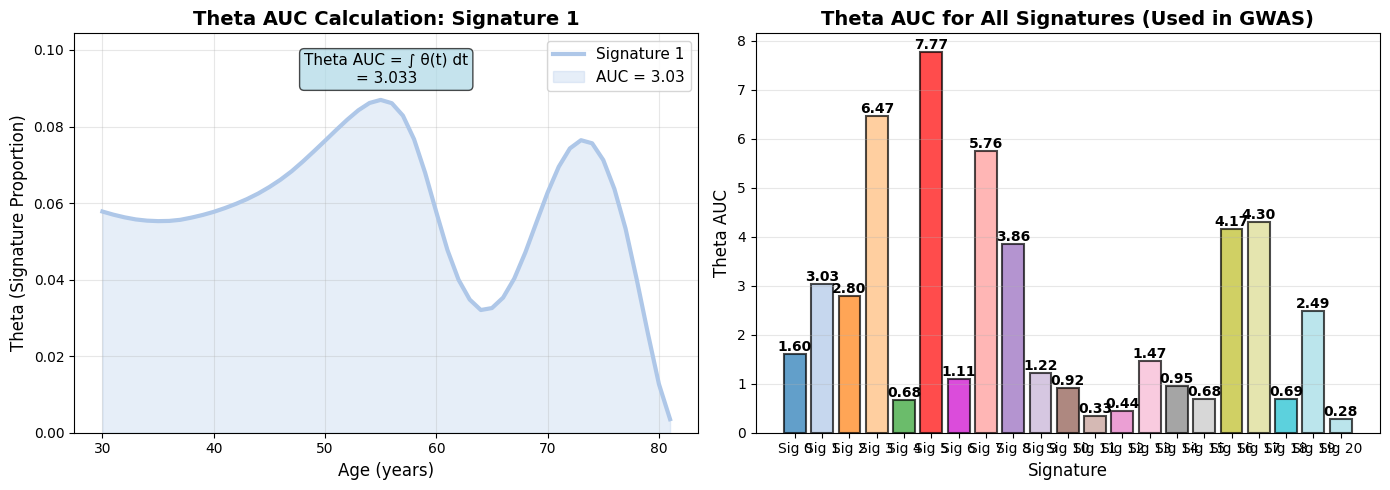


THETA AUC SUMMARY

Theta AUC values (used as phenotypes in GWAS):
  Signature 0: 1.602
  Signature 1: 3.033
  Signature 2: 2.796
  Signature 3: 6.471
  Signature 4: 0.675
  Signature 5: 7.766
  Signature 6: 1.106
  Signature 7: 5.757
  Signature 8: 3.859
  Signature 9: 1.216
  Signature 10: 0.922
  Signature 11: 0.333
  Signature 12: 0.444
  Signature 13: 1.468
  Signature 14: 0.947
  Signature 15: 0.682
  Signature 16: 4.167
  Signature 17: 4.302
  Signature 18: 0.686
  Signature 19: 2.492
  Signature 20: 0.275

Total AUC (should equal number of timepoints): 51.0 (expected: 52)

✓ Theta AUCs can be used as phenotypes for GWAS on each signature!


In [8]:
# Visualize Theta AUC Calculation
# This shows how theta AUC (area under curve) is calculated for GWAS

# Use the same example patient data from above
# Calculate AUC for each signature
theta_aucs = np.zeros(K)
for k in range(K):
    theta_aucs[k] = np.trapz(thetas_patient[k, :], timepoints)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Show AUC calculation for one signature
sig_to_highlight = 1  # Signature 1 (increasing)
ax1 = axes[0]
ax1.plot(timepoints, thetas_patient[sig_to_highlight, :], 
         color=colors[sig_to_highlight], 
         linewidth=3, 
         label=f'Signature {sig_to_highlight}')
ax1.fill_between(timepoints, 0, thetas_patient[sig_to_highlight, :], 
                 color=colors[sig_to_highlight], 
                 alpha=0.3,
                 label=f'AUC = {theta_aucs[sig_to_highlight]:.2f}')

ax1.set_xlabel('Age (years)', fontsize=12)
ax1.set_ylabel('Theta (Signature Proportion)', fontsize=12)
ax1.set_title(f'Theta AUC Calculation: Signature {sig_to_highlight}', 
              fontsize=14, weight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, max(thetas_patient[sig_to_highlight, :]) * 1.2])

# Add annotation explaining AUC
ax1.text(0.5, 0.95, 
         f'Theta AUC = ∫ θ(t) dt\n= {theta_aucs[sig_to_highlight]:.3f}',
         transform=ax1.transAxes, 
         fontsize=11, 
         verticalalignment='top',
         horizontalalignment='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Plot 2: Bar plot of AUCs for all signatures
ax2 = axes[1]
bars = ax2.bar(range(K), theta_aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Signature', fontsize=12)
ax2.set_ylabel('Theta AUC', fontsize=12)
ax2.set_title('Theta AUC for All Signatures (Used in GWAS)', 
              fontsize=14, weight='bold')
ax2.set_xticks(range(K))
ax2.set_xticklabels([f'Sig {k}' for k in range(K)], fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for k, (bar, auc_val) in enumerate(zip(bars, theta_aucs)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{auc_val:.2f}',
             ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("THETA AUC SUMMARY")
print("="*80)
print("\nTheta AUC values (used as phenotypes in GWAS):")
for k in range(K):
    print(f"  Signature {k}: {theta_aucs[k]:.3f}")
print(f"\nTotal AUC (should equal number of timepoints): {theta_aucs.sum():.1f} (expected: {T})")
print(f"\n✓ Theta AUCs can be used as phenotypes for GWAS on each signature!")


---
## Part 3: GWAS AUC Calculation Without Genotypes (G)

### Overview

One powerful feature of Aladynoulli is that we can perform GWAS on signature loadings **without needing genotypes (G)**. Instead, we use:

1. **Lambda** (raw signature loadings) or **Theta** (softmax of lambda) from the model
2. **Theta AUC**: Area under the curve of theta trajectories over time
3. **GWAS**: Regress theta AUCs against genotypes

### Workflow

```
Step 1: Fit model (with or without G)
  ↓
Step 2: Extract lambda (signature loadings) for each patient
  ↓
Step 3: Calculate theta = softmax(lambda) [N, K, T]
  ↓
Step 4: Calculate theta AUC = ∫ theta(t) dt for each signature [N, K]
  ↓
Step 5: Run GWAS: theta_AUC ~ genotype for each signature
```

### Key Insight

The model learns signature loadings (lambda/theta) from disease data (Y, E), which capture genetic and environmental factors. These loadings can then be used as phenotypes for GWAS, even if G was not used in the model fitting.


In [9]:
def softmax(x):
    """
    Compute softmax values for each set of scores in x.
    x shape: (n_individuals, n_signatures, n_timepoints) or (n_individuals, n_signatures)
    """
    if x.ndim == 3:
        # Reshape to (n_individuals * n_timepoints, n_signatures)
        x_reshaped = x.transpose(0, 2, 1).reshape(-1, x.shape[1])
        
        # Compute softmax
        e_x = np.exp(x_reshaped - np.max(x_reshaped, axis=1, keepdims=True))
        softmax_x = e_x / np.sum(e_x, axis=1, keepdims=True)
        
        # Reshape back to original shape
        return softmax_x.reshape(x.shape[0], x.shape[2], x.shape[1]).transpose(0, 2, 1)
    elif x.ndim == 2:
        # Simple 2D case
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    else:
        raise ValueError(f"Expected 2D or 3D array, got {x.ndim}D")


def calculate_theta_aucs(all_lambdas, timepoints=None):
    """
    Calculate theta AUCs from lambda values.
    
    Parameters:
    - all_lambdas: Array of shape (N, K, T) where N=patients, K=signatures, T=timepoints
    - timepoints: Array of timepoints (default: np.arange(T))
    
    Returns:
    - theta_aucs: Array of shape (N, K) with AUC values for each patient-signature pair
    """
    N, K, T = all_lambdas.shape
    
    if timepoints is None:
        timepoints = np.arange(T)
    
    # Calculate thetas using softmax
    all_thetas = softmax(all_lambdas)  # Shape: (N, K, T)
    
    # Calculate AUC for each patient-signature pair
    theta_aucs = np.zeros((N, K))
    for i in range(N):
        for s in range(K):
            theta_aucs[i, s] = np.trapz(all_thetas[i, s, :], timepoints)
    
    return theta_aucs, all_thetas


print("="*80)
print("GWAS AUC CALCULATION WITHOUT GENOTYPES")
print("="*80)
print("\nFunctions created:")
print("  1. softmax(): Converts lambda to theta")
print("  2. calculate_theta_aucs(): Calculates AUC for each patient-signature pair")
print("\nWorkflow:")
print("  1. Load lambda from model (shape: [N, K, T])")
print("  2. Calculate theta = softmax(lambda)")
print("  3. Calculate theta_AUC = ∫ theta(t) dt for each signature")
print("  4. Run GWAS: theta_AUC[:, signature] ~ genotype for each SNP")
print("\nThis allows GWAS on signature loadings without needing G in the model!")


GWAS AUC CALCULATION WITHOUT GENOTYPES

Functions created:
  1. softmax(): Converts lambda to theta
  2. calculate_theta_aucs(): Calculates AUC for each patient-signature pair

Workflow:
  1. Load lambda from model (shape: [N, K, T])
  2. Calculate theta = softmax(lambda)
  3. Calculate theta_AUC = ∫ theta(t) dt for each signature
  4. Run GWAS: theta_AUC[:, signature] ~ genotype for each SNP

This allows GWAS on signature loadings without needing G in the model!


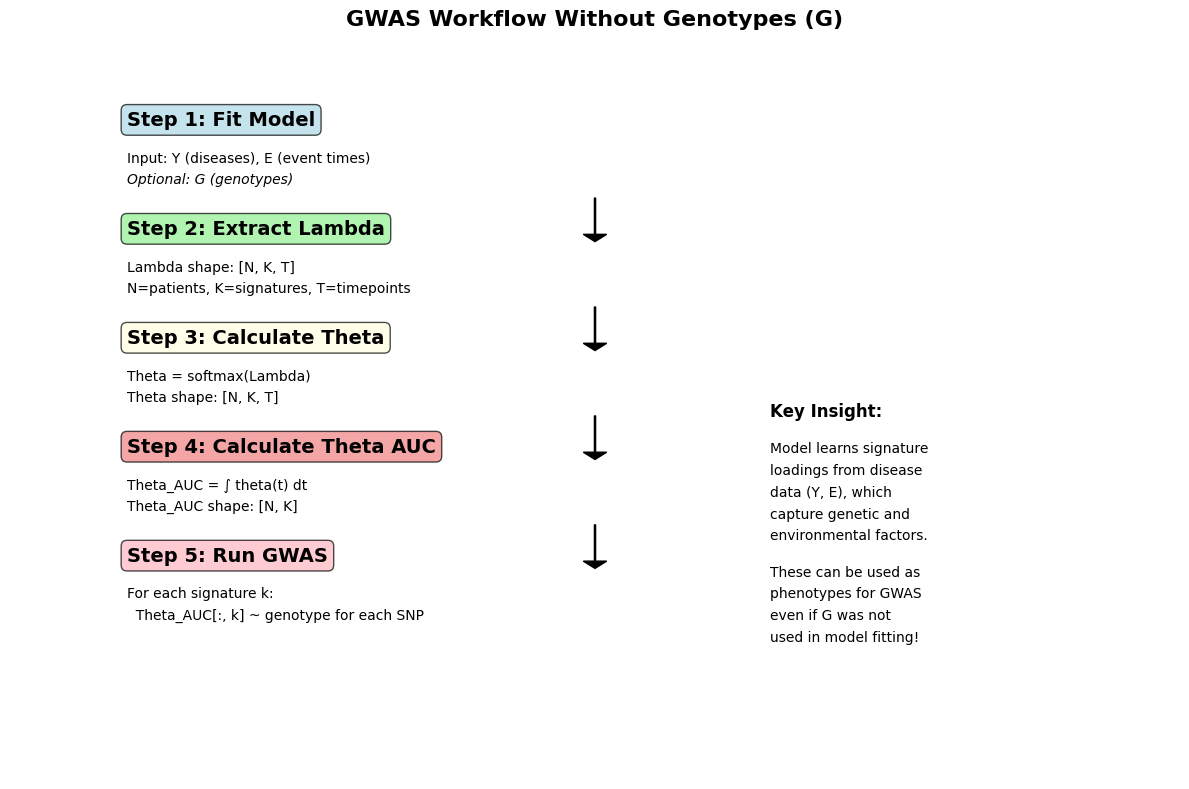


Schematic created showing the complete workflow.


In [10]:
# Example: Schematic visualization of the workflow
def create_gwas_workflow_schematic():
    """
    Create a schematic diagram showing the GWAS workflow without G
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')
    
    # Define positions
    y_start = 0.9
    y_step = 0.15
    
    # Step 1: Model fitting
    ax.text(0.1, y_start, 'Step 1: Fit Model', fontsize=14, weight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    ax.text(0.1, y_start - 0.05, 'Input: Y (diseases), E (event times)', fontsize=10)
    ax.text(0.1, y_start - 0.08, 'Optional: G (genotypes)', fontsize=10, style='italic')
    
    # Arrow
    ax.arrow(0.5, y_start - 0.1, 0, -0.05, head_width=0.02, head_length=0.01, fc='black')
    
    # Step 2: Extract lambda
    y_pos = y_start - y_step
    ax.text(0.1, y_pos, 'Step 2: Extract Lambda', fontsize=14, weight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    ax.text(0.1, y_pos - 0.05, 'Lambda shape: [N, K, T]', fontsize=10)
    ax.text(0.1, y_pos - 0.08, 'N=patients, K=signatures, T=timepoints', fontsize=10)
    
    # Arrow
    ax.arrow(0.5, y_pos - 0.1, 0, -0.05, head_width=0.02, head_length=0.01, fc='black')
    
    # Step 3: Calculate theta
    y_pos = y_pos - y_step
    ax.text(0.1, y_pos, 'Step 3: Calculate Theta', fontsize=14, weight='bold',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    ax.text(0.1, y_pos - 0.05, 'Theta = softmax(Lambda)', fontsize=10)
    ax.text(0.1, y_pos - 0.08, 'Theta shape: [N, K, T]', fontsize=10)
    
    # Arrow
    ax.arrow(0.5, y_pos - 0.1, 0, -0.05, head_width=0.02, head_length=0.01, fc='black')
    
    # Step 4: Calculate theta AUC
    y_pos = y_pos - y_step
    ax.text(0.1, y_pos, 'Step 4: Calculate Theta AUC', fontsize=14, weight='bold',
            bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
    ax.text(0.1, y_pos - 0.05, 'Theta_AUC = ∫ theta(t) dt', fontsize=10)
    ax.text(0.1, y_pos - 0.08, 'Theta_AUC shape: [N, K]', fontsize=10)
    
    # Arrow
    ax.arrow(0.5, y_pos - 0.1, 0, -0.05, head_width=0.02, head_length=0.01, fc='black')
    
    # Step 5: GWAS
    y_pos = y_pos - y_step
    ax.text(0.1, y_pos, 'Step 5: Run GWAS', fontsize=14, weight='bold',
            bbox=dict(boxstyle='round', facecolor='lightpink', alpha=0.7))
    ax.text(0.1, y_pos - 0.05, 'For each signature k:', fontsize=10)
    ax.text(0.1, y_pos - 0.08, '  Theta_AUC[:, k] ~ genotype for each SNP', fontsize=10)
    
    # Side note
    ax.text(0.65, 0.5, 'Key Insight:', fontsize=12, weight='bold')
    ax.text(0.65, 0.45, 'Model learns signature', fontsize=10)
    ax.text(0.65, 0.42, 'loadings from disease', fontsize=10)
    ax.text(0.65, 0.39, 'data (Y, E), which', fontsize=10)
    ax.text(0.65, 0.36, 'capture genetic and', fontsize=10)
    ax.text(0.65, 0.33, 'environmental factors.', fontsize=10)
    ax.text(0.65, 0.28, 'These can be used as', fontsize=10)
    ax.text(0.65, 0.25, 'phenotypes for GWAS', fontsize=10)
    ax.text(0.65, 0.22, 'even if G was not', fontsize=10)
    ax.text(0.65, 0.19, 'used in model fitting!', fontsize=10)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title('GWAS Workflow Without Genotypes (G)', fontsize=16, weight='bold', pad=20)
    
    plt.tight_layout()
    return fig

fig = create_gwas_workflow_schematic()
plt.show()

print("\nSchematic created showing the complete workflow.")


---
## Summary

### Key Takeaways

1. **Discovery Mode (Joint Phi)**:
   - Phi and lambda learned jointly from data
   - Best for understanding disease biology
   - Thetas reflect individual signature loadings learned with batch-specific phi

2. **Prediction Mode (Fixed Phi)**:
   - Phi fixed from master checkpoint
   - Lambda learned given fixed phi
   - Best for clinical predictions
   - Thetas reflect individual signature loadings given stable phi

3. **Theta Updates**:
   - Thetas update as more data becomes available (age offset approach)
   - Higher age offset = more data = more refined thetas
   - Theta AUC captures cumulative signature loading over time

4. **GWAS Without G**:
   - Model learns signature loadings from disease data (Y, E)
   - These loadings capture genetic and environmental factors
   - Can be used as phenotypes for GWAS even if G wasn't in the model
   - Workflow: Lambda → Theta → Theta AUC → GWAS

### Applications

- **Discovery Mode**: Pathway analysis, heritability, population stratification
- **Prediction Mode**: Clinical risk prediction, AUC evaluation, washout validation
- **Theta AUC**: GWAS on signature loadings, genetic architecture of disease signatures
